# Event Catalogue Analysis
**Jared C. Magyar, 2024**

In [1]:
import numpy as np
from obspy.core.inventory import inventory
from cryoquake import data_objects as do
from cryoquake import spatial_analysis as sa
from obspy.core import UTCDateTime
import matplotlib.pyplot as plt
import obspy
from obspy.signal.filter import envelope
import multiprocessing as mp
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import tqdm
import pandas as pd
import os
from matplotlib.dates import DateFormatter, HourLocator, DayLocator
from obspy.imaging.util import _set_xaxis_obspy_dates
from matplotlib import rc


one_col = 3.35 #inches
two_col = 7.0 #inches

rc('text', usetex=True)
rc('font', size=8)
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Optima']})


In [2]:
from pathlib import Path

root = Path().resolve().parent
w_path = root / "waveforms"
c_path = root / "test_catalogues"
stat_path = root / "stations" / "sorsdal_stations.xml"
#stat_path = root / "stations"
p_path = root / "outputs"

w_path

PosixPath('/Users/jmagyar/Documents/icequakecode/projects/sorsdal_analysis/waveforms')

In [11]:
t1 = UTCDateTime(2018,1,14)
t2 = UTCDateTime(2018,1,17)

chunk = do.SeismicChunk(t1,t2)
inv = inventory.read_inventory(stat_path,level='response').select(station='BBS??')


In [ ]:
for daychunk in chunk(24*60*60):

    daychunk.attach_waveforms(inv,w_path,buffer=60*60) #hour long buffer for filtering and STA/LTA
    #chunk.filter('highpass',freq=1)
    daychunk.remove_response(pre_filt=[1,2,45,50],taper=False)
    daychunk.context('detect')
    daychunk.detect_events(c_path,trigger_type='multistalta',sta=0.2,lta=2.0,delta_sta=50,delta_lta=50,epsilon=2,thr_on=4,thr_off=3,thr_coincidence_sum=2,avg_wave_speed=1.5,thr_event_join=5.0) 

In [15]:
#local_path = '/Users/jmagyar/Documents/SorsdalData'
#cloud_path = '/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Outputs/Icequakes'

#c_path = os.path.join(cloud_path,'sorsdal_catalogues')
#stat_path = os.path.join(local_path,'stations/sorsdal_stations.xml')
#w_path = os.path.join(local_path,'waveforms')
#p_path = os.path.join(cloud_path,'event_plots')
#class_path = c_path

inv = inventory.read_inventory(stat_path,level='response')
ref_inv = inv.select(station='REF??')
bbs_inv = inv.select(station='BBS??')
bbs06 = inv.select(station='BBS06')

t1 = UTCDateTime(2018,1,1)
t2 = UTCDateTime(2018,2,15)

chunk = do.SeismicChunk(t1,t2)

In [16]:
attributes = chunk.load_csv(c_path,'waveform_attributes')
attributes.dropna(inplace=True)
mfp = chunk.load_csv(c_path,'mfp_opt')
mfp.dropna(inplace=True)
pol = chunk.load_csv(c_path,'polarisation_localisation_opt')
pol.dropna(inplace=True)

print(len(attributes))

67946


In [17]:
attributes['mfp_baz'] = mfp['baz_opt']
attributes['pol_baz'] = pol['baz_opt']

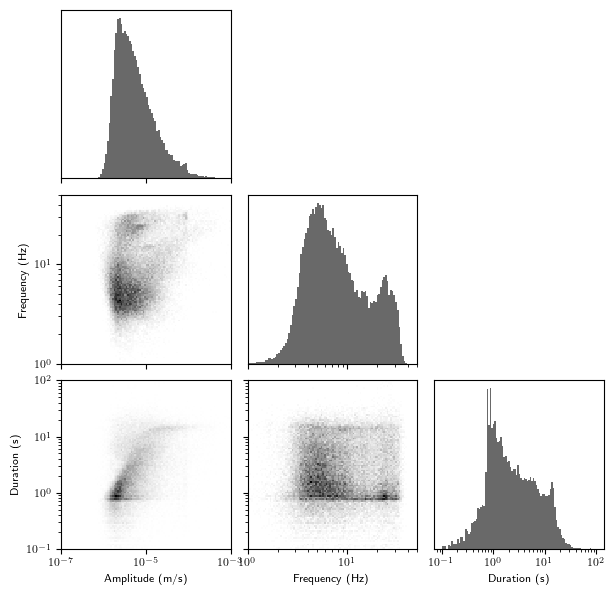

In [5]:
num_bins = 100

fig = plt.figure(figsize=(two_col,two_col))
grid_spec = fig.add_gridspec(ncols=3,nrows=3,width_ratios=[1,1,1],height_ratios=[1,1,1],hspace=0.1,wspace=0.1)

amp_hist = fig.add_subplot(grid_spec[0,0])
freq_hist = fig.add_subplot(grid_spec[1,1])
dur_hist = fig.add_subplot(grid_spec[2,2])

amp_hist.set_xscale('log')
freq_hist.set_xscale('log')
dur_hist.set_xscale('log')

amp_freq = fig.add_subplot(grid_spec[1,0],sharex=amp_hist)
amp_dur = fig.add_subplot(grid_spec[2,0],sharex=amp_hist)
freq_dur = fig.add_subplot(grid_spec[2,1],sharex=freq_hist)

amp_freq.set_xscale('log')
amp_freq.set_yscale('log')
amp_dur.set_xscale('log')
amp_dur.set_yscale('log')
freq_dur.set_yscale('log')
freq_dur.set_xscale('log')

amps = attributes['amplitude'].to_numpy()
freqs = attributes['mean_freq'].to_numpy()
durs = attributes['duration'].to_numpy()

amp_bins = np.geomspace(1e-7,1e-3,num_bins+1)
freq_bins = np.geomspace(1,50,num_bins+1)
dur_bins = np.geomspace(0.1,100,num_bins+1)

amp_count, _ = np.histogram(amps,bins=amp_bins)
freq_count, _ = np.histogram(freqs,bins=freq_bins)
dur_count, _ = np.histogram(durs,bins=dur_bins)

amp_freq_count, _, _ = np.histogram2d(amps,freqs,bins=(amp_bins,freq_bins))
amp_dur_count, _, _ = np.histogram2d(amps,durs,bins=(amp_bins,dur_bins))
freq_dur_count, _, _ = np.histogram2d(freqs,durs,bins=(freq_bins,dur_bins))

freq_hist.bar(freq_bins[:-1],height=freq_count,width=np.diff(freq_bins),align='edge',color='dimgrey')
freq_hist.set_yticks([])

amp_hist.bar(amp_bins[:-1],height=amp_count,width=np.diff(amp_bins),align='edge',color='dimgrey')
amp_hist.set_yticks([])

dur_hist.bar(dur_bins[:-1],height=dur_count,width=np.diff(dur_bins),align='edge',color='dimgrey')
dur_hist.set_yticks([])

amp_dur.set_ylim(dur_hist.get_xlim())
freq_dur.set_ylim(dur_hist.get_xlim())


amp_freq.pcolormesh(amp_bins,freq_bins,amp_freq_count.T,cmap='binary')
amp_dur.pcolormesh(amp_bins,dur_bins,amp_dur_count.T,cmap='binary')
freq_dur.pcolormesh(freq_bins,dur_bins,freq_dur_count.T,cmap='binary')

#quartiles
amp_ylim = amp_hist.get_ylim()
amp_q = np.nanquantile(amps,q=[0.25,0.5,0.75])
#amp_hist.vlines(amp_q,*amp_ylim,colors='red',linestyles=['--','-','--'],lw=0.8,alpha=0.5)
amp_hist.set_ylim(amp_ylim)

freq_ylim = freq_hist.get_ylim()
freq_q = np.nanquantile(freqs,q=[0.25,0.5,0.75])
#freq_hist.vlines(freq_q,*freq_ylim,colors='red',linestyles=['--','-','--'],lw=0.8,alpha=0.5)
freq_hist.set_ylim(freq_ylim)

dur_ylim = dur_hist.get_ylim()
dur_q = np.nanquantile(durs,q=[0.25,0.5,0.75])
#dur_hist.vlines(dur_q,*dur_ylim,colors='red',linestyles=['--','-','--'],lw=0.8,alpha=0.5)
dur_hist.set_ylim(dur_ylim)

#amp_freq.vlines(amp_q,*amp_freq.get_ylim(),colors='red',linestyles=['--','-','--'],lw=0.8,alpha=0.3)
#amp_freq.hlines(freq_q,*amp_freq.get_xlim(),color='red',linestyles=['--','-','--'],lw=0.8,alpha=0.3)
amp_freq.set_xlim(amp_bins[0],amp_bins[-1])
amp_freq.set_ylim(freq_bins[0],freq_bins[-1])

#amp_dur.vlines(amp_q,*amp_dur.get_ylim(),colors='red',linestyles=['--','-','--'],lw=0.8,alpha=0.3)
#amp_dur.hlines(dur_q,*amp_dur.get_xlim(),color='red',linestyles=['--','-','--'],lw=0.8,alpha=0.3)
amp_dur.set_xlim(amp_bins[0],amp_bins[-1])
amp_dur.set_ylim(dur_bins[0],dur_bins[-1])

#freq_dur.vlines(freq_q,*freq_dur.get_ylim(),colors='red',linestyles=['--','-','--'],lw=0.8,alpha=0.3)
#freq_dur.hlines(dur_q,*freq_dur.get_xlim(),color='red',linestyles=['--','-','--'],lw=0.8,alpha=0.3)
freq_dur.set_xlim(freq_bins[0],freq_bins[-1])
freq_dur.set_ylim(dur_bins[0],dur_bins[-1])


plt.setp(freq_hist.get_xticklabels(), visible=False)
plt.setp(amp_hist.get_xticklabels(), visible=False)
plt.setp(amp_freq.get_xticklabels(), visible=False)
plt.setp(freq_dur.get_yticklabels(), visible=False)

amp_freq.set_ylabel('Frequency (Hz)')
amp_dur.set_ylabel('Duration (s)')
amp_dur.set_xlabel('Amplitude (m/s)')
freq_dur.set_xlabel('Frequency (Hz)')
dur_hist.set_xlabel('Duration (s)')

fig.savefig(os.path.join(p_path,'catalogue_attributes.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'catalogue_attributes.pdf'),bbox_inches='tight',dpi=400)

/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_95046/3477145590.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_drop['ang_diff'] = att_drop['mfp_baz'] - att_drop['pol_baz']
/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_95046/3477145590.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  att_drop['ang_diff'] = (att_drop['ang_diff'] + np.pi) % (2*np.pi) - np.pi
/var/folders/z4/gw28hj796zjdxt4nltp_h5g1m6cl00/T/ipykernel_95046/3477145590.py:55: SettingWithCopyWarning: 
A value

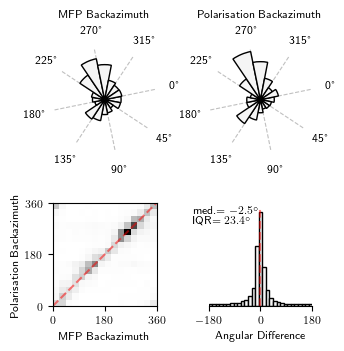

In [6]:
num_bins = 16

fig = plt.figure(figsize=(one_col,one_col))
grid_spec = fig.add_gridspec(ncols=2,nrows=2,width_ratios=[1,1],height_ratios=[1,1],hspace=0.5,wspace=0.5)

mfp_rose = fig.add_subplot(grid_spec[0,0],projection='polar')
pol_rose = fig.add_subplot(grid_spec[0,1],projection='polar',sharey=mfp_rose)

mfp_pol = fig.add_subplot(grid_spec[1,0])

baz_bins = np.linspace(0,2*np.pi,num_bins+1)
baz_bins_deg = np.rad2deg(baz_bins)

att_drop = attributes.dropna()

mfp_count, _ = np.histogram(att_drop['mfp_baz'],bins=baz_bins)
pol_count, _ = np.histogram(att_drop['pol_baz'],bins=baz_bins)

mfp_pol_count, _, _ = np.histogram2d(att_drop['mfp_baz'],att_drop['pol_baz'],(baz_bins,baz_bins))


mfp_pol.pcolormesh(baz_bins_deg,baz_bins_deg,mfp_pol_count.T,cmap='binary')
mfp_pol.plot(baz_bins_deg,baz_bins_deg,ls='--',color='red',alpha=0.5)

mfp_pol.set_xlabel('MFP Backazimuth')
mfp_pol.set_ylabel('Polarisation Backazimuth')

mfp_pol.set_xticks([0,180,360])
mfp_pol.set_yticks([0,180,360])

for rose_ax in [mfp_rose,pol_rose]:
    station_lon = 78.439034
    rose_ax.set_theta_zero_location('N',offset=-station_lon)
    rose_ax.set_theta_direction(-1)
    rose_ax.set_yticks([])
    rose_ax.spines['polar'].set_visible(False)
    rose_ax.xaxis.grid(linestyle='--',color='silver')

mfp_rose.bar(baz_bins[:-1],height=mfp_count,width=np.diff(baz_bins),align='edge',facecolor='whitesmoke',edgecolor='black')#color='dimgrey')
mfp_rose.set_axisbelow(True)
pol_rose.bar(baz_bins[:-1],height=pol_count,width=np.diff(baz_bins),align='edge',facecolor='whitesmoke',edgecolor='black')
pol_rose.set_axisbelow(True)


#mfp_rose.set_title('MFP', rotation='vertical',x=-0.1,y=0.5)
mfp_rose.set_title('MFP Backazimuth',fontsize=8)
pol_rose.set_title('Polarisation Backazimuth',fontsize=8)
#mfp_rose.annotate('MFP',(-0.1,1.1),xycoords='axes fraction')

#pol_rose.set_title('Polarisation')
#mfp_rose.set_title('MFP')

att_drop['ang_diff'] = att_drop['mfp_baz'] - att_drop['pol_baz']
att_drop['ang_diff'] = (att_drop['ang_diff'] + np.pi) % (2*np.pi) - np.pi
att_drop['ang_diff_deg'] = np.rad2deg(att_drop['ang_diff'])

diff_bins = np.linspace(-180,180,30)
hist,_ = np.histogram(att_drop['ang_diff_deg'],bins=diff_bins)

diff_ax = fig.add_subplot(grid_spec[1,1])
diff_ax.bar(diff_bins[:-1],hist,width=np.diff(diff_bins),align='edge',facecolor='whitesmoke',edgecolor='black')#color='dimgrey')

diff_ax.spines['top'].set_visible(False)
diff_ax.spines['left'].set_visible(False)
diff_ax.spines['right'].set_visible(False)

diff_ax.set_yticks([])
diff_ax.set_xticks([-180,0,180])
diff_ax.set_xlim((-180,180))
diff_ax.vlines(0,ymin=0,ymax=diff_ax.get_ylim()[1],ls='--',color='red',alpha=0.5)
diff_ax.set_xlabel('Angular Difference')

st_dev = att_drop['ang_diff_deg'].std()
mean = att_drop['ang_diff_deg'].mean()
q25, med, q75 = att_drop['ang_diff_deg'].quantile([0.25,0.5,0.75])
iqr = q75 - q25

diff_ax.annotate(r'med.$ = {:.1f}^\circ$'.format(med),xy=(-0.15,0.9),xycoords='axes fraction')
diff_ax.annotate(r'IQR$ = {:.1f}^\circ$'.format(iqr),xy=(-0.15,0.8),xycoords='axes fraction')

fig.savefig(os.path.join(p_path,'backazimuth_comparison.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'backazimuth_comparison.pdf'),bbox_inches='tight',dpi=400)

In [8]:
all_templates = {'1a':'20180108T003015Z',
             '1b':'20180114T234955Z',
             '1c':'20180120T132740Z',
             '1d':'20180108T061313Z',
             '2a':'20180108T021558Z',
             '2b':'20180114T165412Z',
             '2c':'20180108T012013Z',
             '2d':'20180114T184018Z',
             '3a':'20180120T084849Z',
             '3b':'20180108T013417Z',
             '3c':'20180114T210649Z',
             '3d':'20180120T081146Z',
             '4a':'20180108T013024Z',
             '4b':'20180120T144129Z',
             '4c':'20180114T171343Z',
             '4d':'20180108T012122Z',
             '5a':'20180108T020737Z',
             '5b':'20180108T020121Z',
             '5c':'20180108T025047Z',
             '5d':'20180108T031250Z',
             '6a':'20180108T023943Z',
             '6b':'20180114T163252Z',
             '6c':'20180108T064747Z',
             '6d':'20180108T010129Z',
             '7a':'20180108T065407Z',
             '7b':'20180114T213023Z',
             '7c':'20180114T212327Z',
             '7d':'20180108T041343Z',
             '8a':'20180108T030040Z',
             '8b':'20180108T075115Z',
             '8c':'20180114T160953Z',
             '8d':'20180120T125805Z'
             }

threshold_dict = {'1':0.8,
                '2':0.75,
                '3':0.65,
                '4':0.75,
                '5':0.75,
                '6':0.75,
                '7':0.65,
                '8':0.65}

In [9]:
#firstly can load in the event catalogue and then just take the events that were classified

event_cat = do.EventCatalogue(t1,t2,c_path)

"""ENVIRONMENTAL DATA"""

env_path = '/Users/jmagyar/Documents/SorsdalData/environmental'

chunk.context('timeseries')
chunk.attach_environmental(env_path)
temp = chunk.env_stream.select(channel='TEM')[0]
tide = chunk.env_stream.select(channel='TID')[0]
phase = chunk.env_stream.select(channel='PHA')[0]


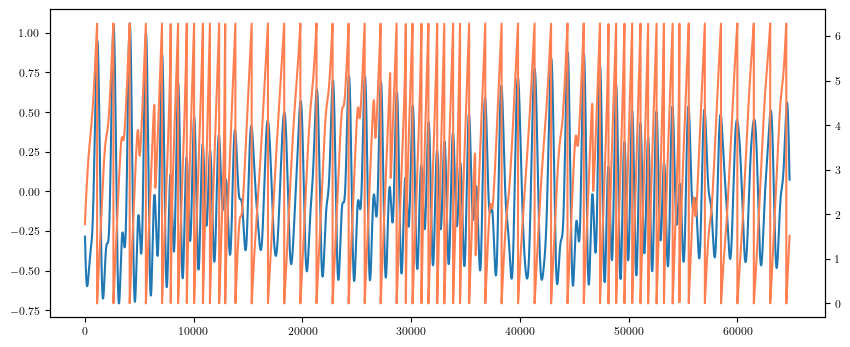

In [19]:
from scipy.signal import hilbert

analytic_signal = hilbert(tide.data)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#plt.plot(tide.data)
fig = plt.figure(figsize=(10,4))
tide_ax = fig.add_subplot(111)
phase_ax = tide_ax.twinx()
tide_ax.plot(tide.data)
phase_ax.plot(instantaneous_phase % (2*np.pi),c='coral')

In [10]:
events = event_cat.events

for event_id, row in attributes.iterrows():
    time = UTCDateTime(events.at[event_id,'ref_time'])
    attributes.at[event_id,'time'] = time.matplotlib_date
    attributes.at[event_id,'diurnal'] = UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date

    dt = time - tide.stats.starttime
    attributes.at[event_id,'tidal'] = np.interp(dt,phase.times(),phase.data)
    

In [11]:
#now want to bin these events according to time in season, time of day, and tidal phase

"""BINNING PARAMETERS"""
daily_bins = 40*60 
total_bins = 24*60*60 
tide_bins = 10 #width in degrees of bins


"""BIN CONSTRUCTION"""
total_bin_edges = np.mgrid[t1:t2:total_bins]
total_bin_edges_mt = np.array([time.matplotlib_date for time in total_bin_edges])

day_start = UTCDateTime(2018,1,1)
day_end = UTCDateTime(2018,1,2)

daily_bin_edges = np.mgrid[day_start:day_end+1:daily_bins]
daily_bin_edges_mt = np.array([time.matplotlib_date for time in daily_bin_edges])

tide_bin_edges = np.mgrid[-180:181:tide_bins]

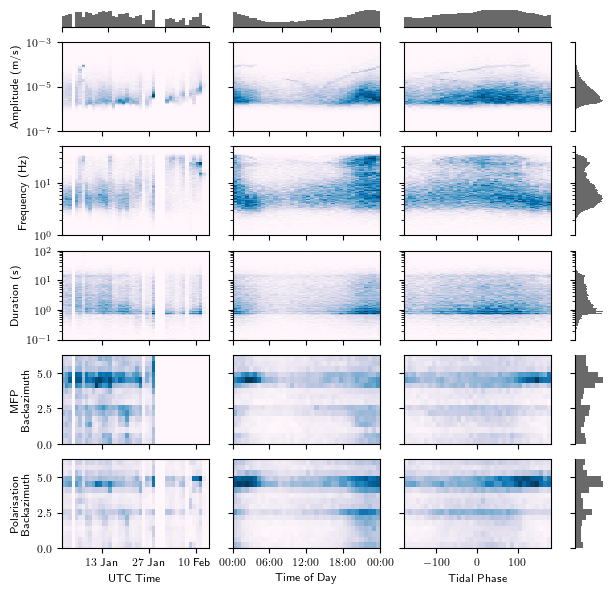

In [12]:
#set up the axes for the plots

fig = plt.figure(figsize=(two_col,two_col))
gs = fig.add_gridspec(ncols=4,nrows=6,height_ratios=[0.2,1,1,1,1,1],width_ratios=[1,1,1,0.2],wspace=0.2,hspace=0.2)

bins = {'time':total_bin_edges_mt,
        'diurnal':daily_bin_edges_mt,
        'tidal':tide_bin_edges,
        'amplitude':amp_bins,
        'mean_freq':freq_bins,
        'duration':dur_bins,
        'mfp_baz':baz_bins,
        'pol_baz':baz_bins}

labels = {'time':'UTC Time',
        'diurnal':'Time of Day',
        'tidal':'Tidal Phase',
        'amplitude':'Amplitude (m/s)',
        'mean_freq':'Frequency (Hz)',
        'duration':'Duration (s)',
        'mfp_baz':'MFP \n Backazimuth',
        'pol_baz':'Polarisation \n Backazimuth'}

for i, x_axis in enumerate(['time','diurnal','tidal']):
    current_ax = fig.add_subplot(gs[0,i])
    hist,_ = np.histogram(attributes[x_axis],bins=bins[x_axis])
    current_ax.bar(bins[x_axis][:-1],hist,width=np.diff(bins[x_axis]),align='edge',color='dimgrey')
    current_ax.set_xlim((bins[x_axis][0],bins[x_axis][-1]))
    current_ax.spines['top'].set_visible(False)
    current_ax.spines['left'].set_visible(False)
    current_ax.spines['right'].set_visible(False)
    current_ax.set_yticks([])
    plt.setp(current_ax.get_xticklabels(), visible=False)

    if x_axis == 'diurnal':
            myFmt = DateFormatter("%H:%M")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(HourLocator(interval=8))

    if x_axis == 'time':
        _set_xaxis_obspy_dates(current_ax)

    
    for j, y_axis in enumerate(['amplitude','mean_freq','duration','mfp_baz','pol_baz']):
        if i == 0:
            current_ax = fig.add_subplot(gs[j+1,-1])
            hist,_ = np.histogram(attributes[y_axis],bins=bins[y_axis])
            current_ax.barh(bins[y_axis][:-1],hist,height=np.diff(bins[y_axis]),align='edge',color='dimgrey')
            current_ax.set_ylim((bins[y_axis][0],bins[y_axis][-1]))

            current_ax.spines['top'].set_visible(False)
            current_ax.spines['bottom'].set_visible(False)
            current_ax.spines['right'].set_visible(False)
            current_ax.set_xticks([])
            plt.setp(current_ax.get_yticklabels(), visible=False)


            if y_axis in ['amplitude','mean_freq','duration']:
                current_ax.set_yscale('log')
        
        current_ax = fig.add_subplot(gs[j+1,i])
        if y_axis in ['amplitude','mean_freq','duration']:
            current_ax.set_yscale('log')
        hist,_,_ = np.histogram2d(attributes[x_axis],attributes[y_axis],bins=(bins[x_axis],bins[y_axis]))
        current_ax.pcolormesh(bins[x_axis],bins[y_axis],hist.T,cmap='PuBu')

        if x_axis == 'diurnal':
            myFmt = DateFormatter("%H:%M")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(HourLocator(interval=6))

        if x_axis == 'time':
            myFmt = DateFormatter("%d %b")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(DayLocator(interval=14))
            #_set_xaxis_obspy_dates(current_ax)

        if j != 4:
            plt.setp(current_ax.get_xticklabels(), visible=False)
        else:
            current_ax.set_xlabel(labels[x_axis])
        if i != 0:
            plt.setp(current_ax.get_yticklabels(), visible=False)
        else:
            current_ax.set_ylabel(labels[y_axis])



fig.savefig(os.path.join(p_path,'attribute_evolution.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'attribute_evolution.pdf'),bbox_inches='tight',dpi=400)

## Group Analysis

Want to make a table of the key properties of each group.

In [13]:
event_cat.add_classification(xcorr.reset_index())
group_cats = event_cat.group_split()

In [14]:
manual_cat = do.EventCatalogue(t1,t2,c_path)
manual_cat.add_classification(pd.read_csv(os.path.join(c_path,'classified_catalogue.csv'),index_col=0))
manual_group_cats = manual_cat.group_split()

/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:663: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_cat = pd.concat(events,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:674: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trace_cat = pd.concat(traces,ignore_index=True)


In [15]:
table = pd.DataFrame(columns=[key for key in threshold_dict.keys()])

for key, thresh in threshold_dict.items():
    table.at['Threshold',key] = thresh
    table.at['Manual N',key] = manual_group_cats[int(key)].N
    table.at['Auto N',key] = group_cats[key].N

    table.at['Manual Amplitude',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['amplitude'].median() * 1e6
    table.at['Auto Amplitude',key] = attributes[attributes.index.isin(group_cats[key].events.index)]['amplitude'].median() * 1e6

    table.at['Manual Frequency',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['mean_freq'].median()
    table.at['Auto Frequency',key] = attributes[attributes.index.isin(group_cats[key].events.index)]['mean_freq'].median()

    table.at['Manual Duration',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['duration'].median()
    table.at['Auto Duration',key] = attributes[attributes.index.isin(group_cats[key].events.index)]['duration'].median()


table

,1,2,3,4,5,6,7,8
Threshold,0.8,0.75,0.65,0.75,0.75,0.75,0.65,0.65
Manual N,183,129,41,81,66,69,116,75
Auto N,2257,890,383,601,102,437,213,471
Manual Amplitude,3.403603,6.529157,2.398598,9.052154,46.293875,7.226846,6.915309,10.839637
Auto Amplitude,4.390422,5.415376,6.301503,6.491252,7.381689,6.01409,7.203094,5.961225
Manual Frequency,6.639579,5.295835,23.22556,7.553115,13.005563,4.623093,3.554144,6.45797
Auto Frequency,6.498171,5.606988,25.503746,7.910224,11.52327,4.997964,3.707945,6.080735
Manual Duration,1.771989,3.431989,1.021988,4.871989,12.226988,3.481989,5.106988,6.211988
Auto Duration,1.961989,2.646988,1.361988,2.591988,2.601988,3.031988,3.531988,2.741989


In [16]:
table.sum(axis=1)

Threshold                5.75
Manual N                  760
Auto N                   5354
Manual Amplitude     92.65918
Auto Amplitude      49.158651
Manual Frequency    70.354859
Auto Frequency      71.829043
Manual Duration     38.125908
Auto Duration       20.470906
dtype: object

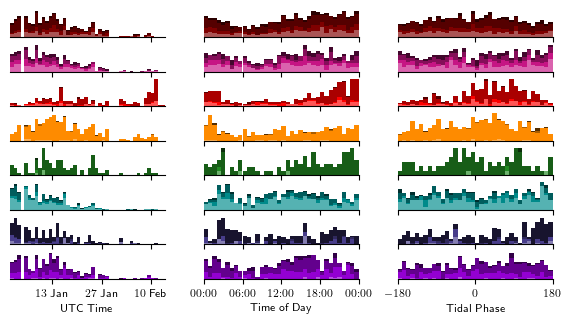

In [17]:
#set up the axes for the plots

fig = plt.figure(figsize=(two_col,0.5*two_col))
gs = fig.add_gridspec(ncols=3,nrows=8,height_ratios=[1,1,1,1,1,1,1,1],width_ratios=[1,1,1],wspace=0.25,hspace=0.25)

c = ['maroon','mediumvioletred','red','darkorange','forestgreen','darkcyan','darkslateblue','darkviolet']

bins = {'time':total_bin_edges_mt,
        'diurnal':daily_bin_edges_mt,
        'tidal':tide_bin_edges,
        'amplitude':amp_bins,
        'mean_freq':freq_bins,
        'duration':dur_bins,
        'mfp_baz':baz_bins,
        'pol_baz':baz_bins}

labels = {'time':'UTC Time',
        'diurnal':'Time of Day',
        'tidal':'Tidal Phase',
        'amplitude':'Amplitude (m/s)',
        'mean_freq':'Frequency (Hz)',
        'duration':'Duration (s)',
        'mfp_baz':'MFP \n Backazimuth',
        'pol_baz':'Polarisation \n Backazimuth'}

for l, x_axis in enumerate(['time','diurnal','tidal']):

    for ii, group in enumerate(threshold_dict):
        current_ax = fig.add_subplot(gs[ii,l])

        sublist = []
        for key in all_templates:
            if key[:-1] == group:
                sublist.append(key)
        templates = {k:all_templates[k] for k in sublist}

        left = mcolors.to_rgb('white')
        middle = mcolors.to_rgb(c[ii])
        right = mcolors.to_rgb('black')

        custom_cm = LinearSegmentedColormap.from_list('custom',[left,middle,right])

        cumulative = np.zeros_like(bins[x_axis][:-1])

        for i, temp_name in enumerate(templates):
                    
            frac = (i+2) / (len(templates)+2)

            group_att = attributes[attributes.index.isin(xcorr[xcorr['template']==temp_name].index)]

            hist, _ = np.histogram(group_att[x_axis],bins=bins[x_axis])

            current_ax.bar(bins[x_axis][:-1],hist,width=np.diff(bins[x_axis]),bottom=cumulative,align='edge',color=custom_cm(frac))

            cumulative += hist

        if x_axis == 'diurnal':
            current_ax.set_xlim(daily_bin_edges_mt[0],daily_bin_edges_mt[-1])
            myFmt = DateFormatter("%H:%M")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(HourLocator(interval=6))

        if x_axis == 'time':
            current_ax.set_xlim(total_bin_edges_mt[0],total_bin_edges_mt[-1])
            myFmt = DateFormatter("%d %b")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(DayLocator(interval=14))
            #_set_xaxis_obspy_dates(current_ax)
        
        if x_axis == 'tidal':
            current_ax.set_xlim((-180,180))
            current_ax.set_xticks([-180,0,180])

        if ii != 7:
            plt.setp(current_ax.get_xticklabels(), visible=False)
        else:
            current_ax.set_xlabel(labels[x_axis])

        current_ax.spines['top'].set_visible(False)
        current_ax.spines['left'].set_visible(False)
        current_ax.spines['right'].set_visible(False)
        current_ax.set_yticks([])


fig.savefig(os.path.join(p_path,'temporal_groups.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'temporal_groups.pdf'),bbox_inches='tight',dpi=400)

### Template Matching

In [18]:
low_temp_cat = do.EventCatalogue(t1,t2,os.path.join(c_path,'low_threshold'),templates=True)
high_temp_cat = do.EventCatalogue(t1,t2,os.path.join(c_path,'high_threshold'),templates=True)


for event_id, row in low_temp_cat.attributes.iterrows():
    time = UTCDateTime(low_temp_cat.events.at[event_id,'ref_time'])
    low_temp_cat.attributes.at[event_id,'time'] = time.matplotlib_date
    low_temp_cat.attributes.at[event_id,'diurnal'] = UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date

    dt = time - tide.stats.starttime
    low_temp_cat.attributes.at[event_id,'tidal'] = np.interp(dt,phase.times(),phase.data)
    low_temp_cat.attributes.at[event_id,'group_num'] = row['group'][0]

for event_id, row in high_temp_cat.attributes.iterrows():
    time = UTCDateTime(high_temp_cat.events.at[event_id,'ref_time'])
    high_temp_cat.attributes.at[event_id,'time'] = time.matplotlib_date
    high_temp_cat.attributes.at[event_id,'diurnal'] = UTCDateTime(2018,1,1,time.hour,time.minute,time.second).matplotlib_date

    dt = time - tide.stats.starttime
    high_temp_cat.attributes.at[event_id,'tidal'] = np.interp(dt,phase.times(),phase.data)
    high_temp_cat.attributes.at[event_id,'group_num'] = row['group'][0]

/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:663: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  event_cat = pd.concat(events,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_objects.py:674: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trace_cat = pd.concat(traces,ignore_index=True)
/Users/jmagyar/Library/Mobile Documents/com~apple~CloudDocs/Code/Icequakes_remote/iqvis/data_o

In [19]:
high_temp_cat.attributes['group_num'].value_counts()

group_num
2    2857
3    2290
1    1800
5    1067
4    1058
6     886
8     844
7     276
Name: count, dtype: int64

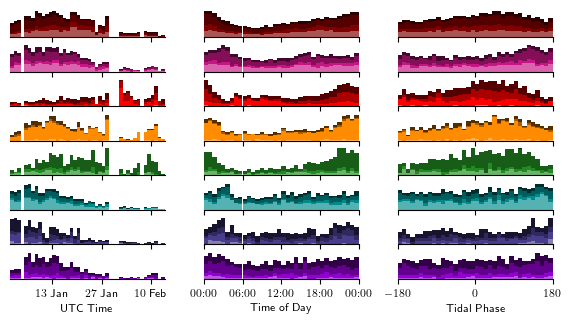

In [20]:
#set up the axes for the plots

temp_att = low_temp_cat.attributes

fig = plt.figure(figsize=(two_col,0.5*two_col))
gs = fig.add_gridspec(ncols=3,nrows=8,height_ratios=[1,1,1,1,1,1,1,1],width_ratios=[1,1,1],wspace=0.25,hspace=0.25)

c = ['maroon','mediumvioletred','red','darkorange','forestgreen','darkcyan','darkslateblue','darkviolet']

bins = {'time':total_bin_edges_mt,
        'diurnal':daily_bin_edges_mt,
        'tidal':tide_bin_edges,
        'amplitude':amp_bins,
        'mean_freq':freq_bins,
        'duration':dur_bins,
        'mfp_baz':baz_bins,
        'pol_baz':baz_bins}

labels = {'time':'UTC Time',
        'diurnal':'Time of Day',
        'tidal':'Tidal Phase',
        'amplitude':'Amplitude (m/s)',
        'mean_freq':'Frequency (Hz)',
        'duration':'Duration (s)',
        'mfp_baz':'MFP \n Backazimuth',
        'pol_baz':'Polarisation \n Backazimuth'}


for l, x_axis in enumerate(['time','diurnal','tidal']):

    for ii, group in enumerate(threshold_dict):
        current_ax = fig.add_subplot(gs[ii,l])

        sublist = []
        for key in all_templates:
            if key[:-1] == group:
                sublist.append(key)
        templates = {k:all_templates[k] for k in sublist}

        left = mcolors.to_rgb('white')
        middle = mcolors.to_rgb(c[ii])
        right = mcolors.to_rgb('black')

        custom_cm = LinearSegmentedColormap.from_list('custom',[left,middle,right])

        cumulative = np.zeros_like(bins[x_axis][:-1])

        for i, temp_name in enumerate(templates):
                    
            frac = (i+2) / (len(templates)+2)

            group_att = temp_att[temp_att['group']==temp_name]

            hist, _ = np.histogram(group_att[x_axis],bins=bins[x_axis])

            current_ax.bar(bins[x_axis][:-1],hist,width=np.diff(bins[x_axis]),bottom=cumulative,align='edge',color=custom_cm(frac))

            cumulative += hist

        if x_axis == 'diurnal':
            current_ax.set_xlim(daily_bin_edges_mt[0],daily_bin_edges_mt[-1])
            myFmt = DateFormatter("%H:%M")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(HourLocator(interval=6))

        if x_axis == 'time':
            current_ax.set_xlim(total_bin_edges_mt[0],total_bin_edges_mt[-1])
            myFmt = DateFormatter("%d %b")
            current_ax.xaxis.set_major_formatter(myFmt)
            current_ax.xaxis.set_major_locator(DayLocator(interval=14))
            #_set_xaxis_obspy_dates(current_ax)
        
        if x_axis == 'tidal':
            current_ax.set_xlim((-180,180))
            current_ax.set_xticks([-180,0,180])

        if ii != 7:
            plt.setp(current_ax.get_xticklabels(), visible=False)
        else:
            current_ax.set_xlabel(labels[x_axis])

        current_ax.spines['top'].set_visible(False)
        current_ax.spines['left'].set_visible(False)
        current_ax.spines['right'].set_visible(False)
        current_ax.set_yticks([])


fig.savefig(os.path.join(p_path,'template_temporal_groups.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'template_temporal_groups.pdf'),bbox_inches='tight',dpi=400)

In [21]:
fine_bins = np.array([time.matplotlib_date for time in np.mgrid[chunk.starttime:chunk.endtime+1:60*60]])
stalta_hist, _ = np.histogram(attributes['time'],bins=fine_bins)
temp_hist, _ = np.histogram(temp_att['time'],bins=fine_bins)

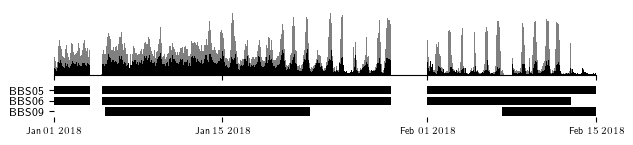

In [22]:
fig = plt.figure(figsize=(two_col,0.2*two_col))
gs = fig.add_gridspec(nrows=2,height_ratios=[2,1])
ax = fig.add_subplot(gs[0])

ax.bar(fine_bins[:-1],stalta_hist,width=np.diff(fine_bins),color='grey')
ax.bar(fine_bins[:-1],temp_hist,width=np.diff(fine_bins),color='black')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])
plt.setp(ax.get_xticklabels(), visible=False)


#ax.set_xlim(total_bin_edges_mt[0],total_bin_edges_mt[-1])
#myFmt = DateFormatter("%d %b")
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(DayLocator(interval=7))

avail = pd.read_csv('stream_availability.csv')
avail_ax = fig.add_subplot(gs[1],sharex=ax)

i = 0
labels = []
coords = []
for net in inv.select(station='BBS??',channel='??Z'):
    for sta in net:
        for ch in sta:
            i -= 1
            subset = avail[(avail['Network']==net.code) & (avail['Station']==sta.code) & (avail['Channel']==ch.code)]
            start = np.array([UTCDateTime(time).matplotlib_date for time in subset['Start']])#pd.to_datetime(subset['Start'])# + pd.Timedelta(hours=chunk.time_offset)
            end = np.array([UTCDateTime(time).matplotlib_date for time in subset['End']])#pd.to_datetime(subset['End']) #+ pd.Timedelta(hours=chunk.time_offset)
            duration = end - start

            
            avail_ax.barh(i,duration,left=start,color='black')
            coords.append(i)
            labels.append(sta.code)

avail_ax.set_yticks(coords)
avail_ax.set_yticklabels(labels)
avail_ax.spines['right'].set_visible(False)
avail_ax.spines['left'].set_visible(False)
avail_ax.spines['top'].set_visible(False)
avail_ax.spines['bottom'].set_visible(False)

avail_ax.set_xlim((fine_bins[0],fine_bins[-1]))
_set_xaxis_obspy_dates(avail_ax)
fig.savefig(os.path.join(p_path,'template_trigger_comp.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'template_trigger_comp.pdf'),bbox_inches='tight',dpi=400)


In [34]:
fine_bins = np.array([time.matplotlib_date for time in np.mgrid[chunk.starttime:chunk.endtime+1:2*60*60]])
stalta_hist, _ = np.histogram(attributes['time'],bins=fine_bins)
temp_hist, _ = np.histogram(temp_att['time'],bins=fine_bins)

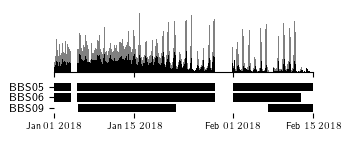

In [35]:
fig = plt.figure(figsize=(one_col,0.4*one_col))
gs = fig.add_gridspec(nrows=2,height_ratios=[2,1])
ax = fig.add_subplot(gs[0])

ax.bar(fine_bins[:-1],stalta_hist,width=np.diff(fine_bins),color='grey')
ax.bar(fine_bins[:-1],temp_hist,width=np.diff(fine_bins),color='black')

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([])
plt.setp(ax.get_xticklabels(), visible=False)


#ax.set_xlim(total_bin_edges_mt[0],total_bin_edges_mt[-1])
#myFmt = DateFormatter("%d %b")
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(DayLocator(interval=7))

avail = pd.read_csv('stream_availability.csv')
avail_ax = fig.add_subplot(gs[1],sharex=ax)

i = 0
labels = []
coords = []
for net in inv.select(station='BBS??',channel='??Z'):
    for sta in net:
        for ch in sta:
            i -= 1
            subset = avail[(avail['Network']==net.code) & (avail['Station']==sta.code) & (avail['Channel']==ch.code)]
            start = np.array([UTCDateTime(time).matplotlib_date for time in subset['Start']])#pd.to_datetime(subset['Start'])# + pd.Timedelta(hours=chunk.time_offset)
            end = np.array([UTCDateTime(time).matplotlib_date for time in subset['End']])#pd.to_datetime(subset['End']) #+ pd.Timedelta(hours=chunk.time_offset)
            duration = end - start

            
            avail_ax.barh(i,duration,left=start,color='black')
            coords.append(i)
            labels.append(sta.code)

avail_ax.set_yticks(coords)
avail_ax.set_yticklabels(labels)
avail_ax.spines['right'].set_visible(False)
avail_ax.spines['left'].set_visible(False)
avail_ax.spines['top'].set_visible(False)
avail_ax.spines['bottom'].set_visible(False)

avail_ax.set_xlim((fine_bins[0],fine_bins[-1]))
_set_xaxis_obspy_dates(avail_ax)
fig.savefig(os.path.join(p_path,'template_trigger_comp_narrow.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'template_trigger_comp_narrow.pdf'),bbox_inches='tight',dpi=400)


In [23]:
temp_wave_att = chunk.load_csv(c_path,'template_waveform_attributes')
temp_att['amplitude'] = temp_wave_att['amplitude']
temp_att['mean_freq'] = temp_wave_att['mean_freq']
temp_att['duration'] = temp_wave_att['duration']

In [24]:
table = pd.DataFrame(columns=[key for key in threshold_dict.keys()])

for key, thresh in threshold_dict.items():
    table.at['Threshold',key] = thresh
    table.at['Manual N',key] = manual_group_cats[int(key)].N
    table.at['Auto N',key] = len(temp_att[temp_att['group_num']==key])

    table.at['Manual Amplitude',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['amplitude'].median() * 1e6
    table.at['Auto Amplitude',key] = temp_att[temp_att['group_num']==key]['amplitude'].median() * 1e6

    table.at['Manual Frequency',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['mean_freq'].median()
    table.at['Auto Frequency',key] = temp_att[temp_att['group_num']==key]['mean_freq'].median()

    table.at['Manual Duration',key] = attributes[attributes.index.isin(manual_group_cats[int(key)].events.index)]['duration'].median()
    table.at['Auto Duration',key] = temp_att[temp_att['group_num']==key]['duration'].median()

table.T

,Threshold,Manual N,Auto N,Manual Amplitude,Auto Amplitude,Manual Frequency,Auto Frequency,Manual Duration,Auto Duration
1,0.8,183,13061,3.403603,3.09312,6.639579,6.392771,1.771989,2.661988
2,0.75,129,4650,6.529157,3.361731,5.295835,5.441227,3.431989,5.761988
3,0.65,41,4238,2.398598,3.96826,23.22556,20.069768,1.021988,1.051989
4,0.75,81,1281,9.052154,5.659597,7.553115,7.750757,4.871989,14.651988
5,0.75,66,1298,46.293875,4.056735,13.005563,9.411232,12.226988,7.461988
6,0.75,69,2362,7.226846,3.841124,4.623093,4.666809,3.481989,5.931988
7,0.65,116,1080,6.915309,5.532497,3.554144,3.588645,5.106988,2.571988
8,0.65,75,1871,10.839637,4.900781,6.45797,5.448692,6.211988,7.541989


In [25]:
table.sum(axis=1)

Threshold                5.75
Manual N                  760
Auto N                  29841
Manual Amplitude     92.65918
Auto Amplitude      34.413845
Manual Frequency    70.354859
Auto Frequency      62.769901
Manual Duration     38.125908
Auto Duration       47.635906
dtype: object

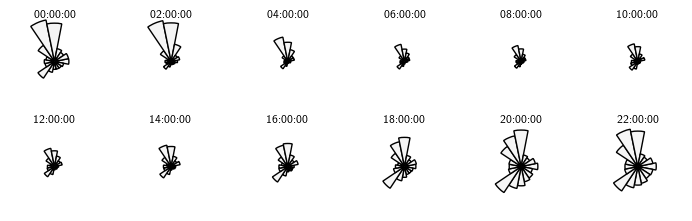

In [26]:
fig, axes = plt.subplots(figsize=(two_col,0.3*two_col),ncols=6,nrows=2,sharey=True,subplot_kw={'projection': 'polar'},layout='constrained')
axes = axes.flatten()
time_bins = np.mgrid[day_start:day_end+1:2*60*60]
time_bins_mt = [time.matplotlib_date for time in time_bins]
hist,_,_ = np.histogram2d(attributes['diurnal'],attributes['pol_baz'],bins=(time_bins_mt,bins['pol_baz']))

for i in range(12):
    hist_slice = hist[i,:]

    rose_ax = axes[i]

    rose_ax.set_theta_zero_location('N',offset=-station_lon)
    rose_ax.set_theta_direction(-1)
    rose_ax.set_xticks([])
    rose_ax.set_yticks([])
    rose_ax.spines['polar'].set_visible(False)

    rose_ax.bar(bins['pol_baz'][:-1],hist_slice,width=np.diff(bins['pol_baz']),align='edge',facecolor='whitesmoke',edgecolor='black')
    rose_ax.annotate(time_bins[i].strftime('%H:%M:%S'),(0.5,1),xycoords='axes fraction',ha='center')

fig.savefig(os.path.join(p_path,'spatio_temp_dist.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'spatio_temp_dist.pdf'),bbox_inches='tight',dpi=400)

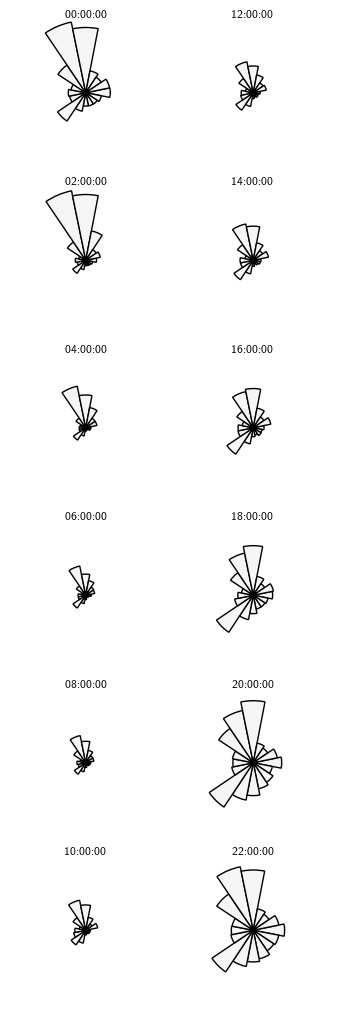

In [32]:
fig, axes = plt.subplots(figsize=(one_col,3*one_col),ncols=2,nrows=6,sharey=True,subplot_kw={'projection': 'polar'},layout='constrained')
axes = axes.flatten(order='F')
time_bins = np.mgrid[day_start:day_end+1:2*60*60]
time_bins_mt = [time.matplotlib_date for time in time_bins]
hist,_,_ = np.histogram2d(attributes['diurnal'],attributes['pol_baz'],bins=(time_bins_mt,bins['pol_baz']))

for i in range(12):
    hist_slice = hist[i,:]

    rose_ax = axes[i]

    rose_ax.set_theta_zero_location('N',offset=-station_lon)
    rose_ax.set_theta_direction(-1)
    rose_ax.set_xticks([])
    rose_ax.set_yticks([])
    rose_ax.spines['polar'].set_visible(False)

    rose_ax.bar(bins['pol_baz'][:-1],hist_slice,width=np.diff(bins['pol_baz']),align='edge',facecolor='whitesmoke',edgecolor='black')
    rose_ax.annotate(time_bins[i].strftime('%H:%M:%S'),(0.5,1),xycoords='axes fraction',ha='center')

fig.savefig(os.path.join(p_path,'spatio_temp_dist_narrow.eps'),bbox_inches='tight',dpi=400)
fig.savefig(os.path.join(p_path,'spatio_temp_dist_narrow.pdf'),bbox_inches='tight',dpi=400)

In [28]:
day_start.strftime('%H:%M:%S')

'00:00:00'

In [29]:
time_bins[0].strftime('%H:%M:%S')

'00:00:00'